In [28]:
# Import Libraries
import math
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import timedelta

In [17]:
# Define Solar Plant Data File
sunlab_minute = pd.read_csv('Sunlab_Faro_Cleaned.csv')

# Ensure Datetime is in datetime format
sunlab_minute['Datetime'] = pd.to_datetime(sunlab_minute['Datetime'])

# Sort the data by datetime for readability
sunlab_minute = sunlab_minute.sort_values(by='Datetime')

In [18]:
sunlab_minute.head()

,Datetime,A_Vertical - Voltage DC [V],A_Vertical - Current DC [A],A_Vertical - Power DC [W],A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Horizontal - Voltage DC [V],A_Horizontal - Current DC [A],A_Horizontal - Power DC [W],...,Solar_Month,Ambient Temperature [ÂºC],Global Radiation [W/m2],Diffuse Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [Âº],Precipitation [mm],Atmospheric pressure [hPa],Meteo_Month
0,2017-01-20 07:52:00+00:00,19.25,0.0750,1.44375,21.60,0.1075,2.322000,18.80,0.0650,1.222,...,1,4.900000,7.267174,6.914082,1.353073,3.600000,331.65972,0.0,1013.7668,1
1,2017-01-20 07:53:00+00:00,19.25,0.0850,1.63625,32.15,0.0450,1.446750,18.80,0.0725,1.363,...,1,4.983333,8.119104,7.055244,1.416638,3.900000,330.66696,0.0,1013.7668,1
2,2017-01-20 07:54:00+00:00,19.20,0.1175,2.25600,32.75,0.0450,1.473750,18.75,0.0800,1.500,...,1,5.000000,8.641460,8.173192,1.483865,3.550000,330.99438,0.0,1013.7834,1
3,2017-01-20 07:55:00+00:00,19.30,0.2775,5.35575,32.95,0.1650,5.436750,18.75,0.1000,1.875,...,1,5.000000,9.611446,8.830058,1.548960,3.500000,330.83166,0.0,1013.8000,1
4,2017-01-20 07:56:00+00:00,19.20,0.4900,9.40800,30.15,0.4375,13.190625,18.85,0.1200,2.262,...,1,5.000000,12.314148,10.599564,1.618800,4.316667,332.66656,0.0,1013.7834,1


In [20]:
sunlab_minute.tail()

,Datetime,A_Vertical - Voltage DC [V],A_Vertical - Current DC [A],A_Vertical - Power DC [W],A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Horizontal - Voltage DC [V],A_Horizontal - Current DC [A],A_Horizontal - Power DC [W],...,Solar_Month,Ambient Temperature [ÂºC],Global Radiation [W/m2],Diffuse Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [Âº],Precipitation [mm],Atmospheric pressure [hPa],Meteo_Month
200686,2017-12-31 16:57:00+00:00,26.70,0.0300,0.80100,29.45,0.0325,0.957125,19.05,0.0925,1.762125,...,12,16.800002,14.352264,13.914030,1.323520,5.100000,298.50012,0.0,1026.4166,12
200687,2017-12-31 16:58:00+00:00,26.35,0.0300,0.79050,29.30,0.0350,1.025500,19.05,0.0900,1.714500,...,12,16.800002,13.566784,13.608252,1.285211,3.850001,276.45834,0.0,1026.4500,12
200688,2017-12-31 16:59:00+00:00,25.80,0.0275,0.70950,17.75,0.0850,1.508750,19.05,0.0850,1.619250,...,12,16.800002,13.325932,13.177236,1.243477,4.450000,276.37098,0.0,1026.4834,12
200689,2017-12-31 17:00:00+00:00,24.70,0.0275,0.67925,28.60,0.0350,1.001000,18.95,0.0750,1.421250,...,12,16.800002,12.727142,12.790736,1.215823,4.966667,295.83680,0.0,1026.5000,12
200690,2017-12-31 17:01:00+00:00,21.40,0.0325,0.69550,28.10,0.0350,0.983500,28.55,0.0250,0.713750,...,12,16.800002,11.669994,11.455128,1.205234,4.416667,295.66842,0.0,1026.5000,12


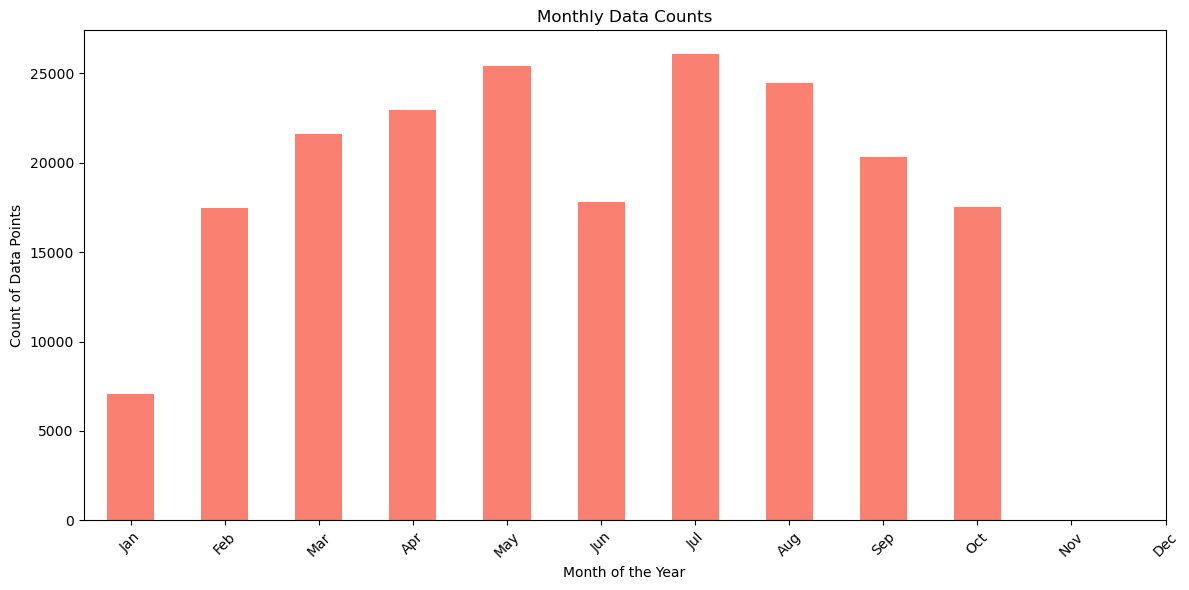

In [21]:
# Extract month from datetime
sunlab_minute['Solar_Month'] = sunlab_minute['Datetime'].dt.month

# group data by month for plotting
monthly_data_count = sunlab_minute.groupby('Solar_Month').size()

# Plot bar chart
plt.figure(figsize=(12,6))
monthly_data_count.plot(kind='bar', color='salmon')
plt.title('Monthly Data Counts')
plt.xlabel('Month of the Year')
plt.ylabel('Count of Data Points')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# Create hourly column
sunlab_minute['Hour'] = sunlab_minute['Datetime'].dt.floor('h')

In [23]:
sunlab_minute.columns.tolist()

['Datetime',
 'A_Vertical - Voltage DC [V]',
 'A_Vertical - Current DC [A]',
 'A_Vertical - Power DC [W]',
 'A_Optimal - Voltage DC [V]',
 'A_Optimal - Current DC [A]',
 'A_Optimal - Power DC [W]',
 'A_Horizontal - Voltage DC [V]',
 'A_Horizontal - Current DC [A]',
 'A_Horizontal - Power DC [W]',
 'A_Vertical - Temperature [ÂºC]',
 'A_Optimal - Temperature [ÂºC]',
 'A_Horizontal - Temperature [ÂºC]',
 'B_Vertical - Voltage DC [V]',
 'B_Vertical - Current DC [A]',
 'B_Vertical - Power DC [W]',
 'B_Optimal - Voltage DC [V]',
 'B_Optimal - Current DC [A]',
 'B_Optimal - Power DC [W]',
 'B_Horizontal - Voltage DC [V]',
 'B_Horizontal - Current DC [A]',
 'B_Horizontal - Power DC [W]',
 'B_Vertical - Temperature [ÂºC]',
 'B_Optimal - Temperature [ÂºC]',
 'B_Horizontal - Temperature [ÂºC]',
 'Solar_Month',
 'Ambient Temperature [ÂºC]',
 'Global Radiation [W/m2]',
 'Diffuse Radiation [W/m2]',
 'Ultraviolet [W/m2]',
 'Wind Velocity [m/s]',
 'Wind Direction [Âº]',
 'Precipitation [mm]',
 'Atmosp

In [24]:
# extract features that may impact efficiency
features = ['Ambient Temperature [ÂºC]', 'Global Radiation [W/m2]', 'Diffuse Radiation [W/m2]', 
            'Ultraviolet [W/m2]', 'Wind Velocity [m/s]', 'Wind Direction [Âº]', 'Precipitation [mm]', 'Atmospheric pressure [hPa]']

# define efficiency ( we will assume Power output / Global Radiation is a good indication for efficiency)
target = 'Efficiency'
# add efficiency column to dataframe
sunlab_minute['Efficiency'] = sunlab_minute['A_Optimal - Power DC [W]'] / sunlab_minute['Global Radiation [W/m2]']
sunlab_minute['Efficiency'] = sunlab_minute['Efficiency'].fillna(0)

In [25]:
sunlab_minute.head()

,Datetime,A_Vertical - Voltage DC [V],A_Vertical - Current DC [A],A_Vertical - Power DC [W],A_Optimal - Voltage DC [V],A_Optimal - Current DC [A],A_Optimal - Power DC [W],A_Horizontal - Voltage DC [V],A_Horizontal - Current DC [A],A_Horizontal - Power DC [W],...,Global Radiation [W/m2],Diffuse Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [Âº],Precipitation [mm],Atmospheric pressure [hPa],Meteo_Month,Hour,Efficiency
0,2017-01-20 07:52:00+00:00,19.25,0.0750,1.44375,21.60,0.1075,2.322000,18.80,0.0650,1.222,...,7.267174,6.914082,1.353073,3.600000,331.65972,0.0,1013.7668,1,2017-01-20 07:00:00+00:00,0.319519
1,2017-01-20 07:53:00+00:00,19.25,0.0850,1.63625,32.15,0.0450,1.446750,18.80,0.0725,1.363,...,8.119104,7.055244,1.416638,3.900000,330.66696,0.0,1013.7668,1,2017-01-20 07:00:00+00:00,0.178191
2,2017-01-20 07:54:00+00:00,19.20,0.1175,2.25600,32.75,0.0450,1.473750,18.75,0.0800,1.500,...,8.641460,8.173192,1.483865,3.550000,330.99438,0.0,1013.7834,1,2017-01-20 07:00:00+00:00,0.170544
3,2017-01-20 07:55:00+00:00,19.30,0.2775,5.35575,32.95,0.1650,5.436750,18.75,0.1000,1.875,...,9.611446,8.830058,1.548960,3.500000,330.83166,0.0,1013.8000,1,2017-01-20 07:00:00+00:00,0.565654
4,2017-01-20 07:56:00+00:00,19.20,0.4900,9.40800,30.15,0.4375,13.190625,18.85,0.1200,2.262,...,12.314148,10.599564,1.618800,4.316667,332.66656,0.0,1013.7834,1,2017-01-20 07:00:00+00:00,1.071176


In [26]:
# normalize features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
sunlab_minute[features] = scaler_X.fit_transform(sunlab_minute[features].values)
sunlab_minute['Efficiency'] = scaler_y.fit_transform(sunlab_minute[['Efficiency']].values)

# convert df to numpy array
solar_data = sunlab_minute[features + ['Efficiency']].values

In [27]:
# create sequence datasets
class SolarDataset(Dataset):
    def __init__(self, data, seq_length=24):
        self.seq_length = seq_length
        self.data = data
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, index):
        X = self.data[index:index+self.seq_length, :-1] 
        y = self.data[index+self.seq_length, -1]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Let's set for 24 hours
seq_length = 24

# Create dataset
dataset = SolarDataset(solar_data, seq_length=seq_length)

In [29]:
# split data for train, validation, test
train_size = int(0.8 * len(dataset)) 
val_size = int(0.1 * len(dataset))  
test_size = len(dataset) - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes to confirm
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 160533
Validation size: 20066
Test size: 20068


In [31]:
class LSTMEfficiencyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMEfficiencyModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Initialize states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Take the last timestep output for final prediction
        out = self.fc(out[:, -1, :])  
        return out


In [33]:
# Define model parameters
input_size = len(features)  
hidden_size = 64         
num_layers = 2         

# init the model
model = LSTMEfficiencyModel(input_size, hidden_size, num_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 15
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    # Training phase
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}")


Epoch 1/15, Train Loss: 0.00039, Validation Loss: 0.00038
Epoch 2/15, Train Loss: 0.00039, Validation Loss: 0.00037
Epoch 3/15, Train Loss: 0.00039, Validation Loss: 0.00041
Epoch 4/15, Train Loss: 0.00038, Validation Loss: 0.00039
Epoch 5/15, Train Loss: 0.00038, Validation Loss: 0.00036
Epoch 6/15, Train Loss: 0.00038, Validation Loss: 0.00038
Epoch 7/15, Train Loss: 0.00038, Validation Loss: 0.00037
Epoch 8/15, Train Loss: 0.00038, Validation Loss: 0.00036
Epoch 9/15, Train Loss: 0.00037, Validation Loss: 0.00038
Epoch 10/15, Train Loss: 0.00037, Validation Loss: 0.00036
Epoch 11/15, Train Loss: 0.00037, Validation Loss: 0.00036
Epoch 12/15, Train Loss: 0.00037, Validation Loss: 0.00036
Epoch 13/15, Train Loss: 0.00037, Validation Loss: 0.00036
Epoch 14/15, Train Loss: 0.00037, Validation Loss: 0.00035
Epoch 15/15, Train Loss: 0.00036, Validation Loss: 0.00039


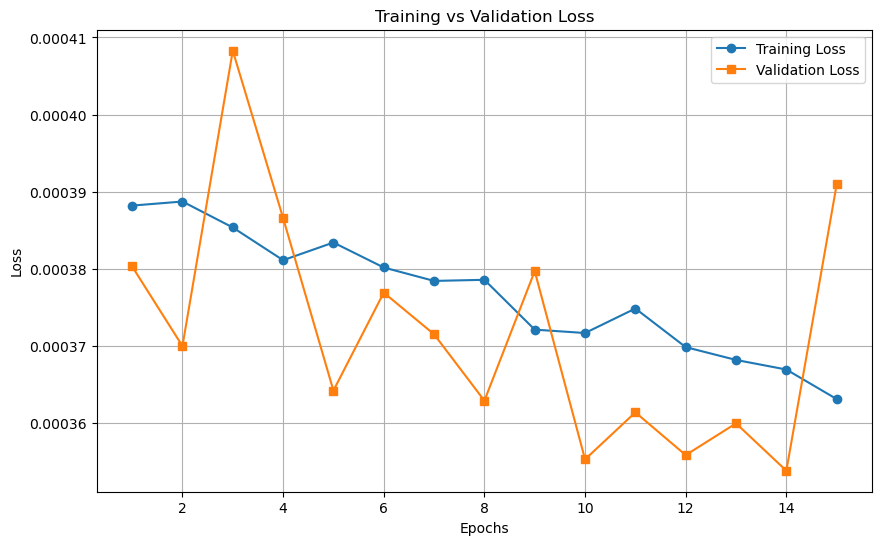

In [37]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="s")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [44]:
# validate model with test holdout
model.eval()
test_loss = 0
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        test_loss += loss.item()

        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

test_loss /= len(test_loader)
print(f"Final Test Loss: {test_loss:.5f}")


Final Test Loss: 0.00042


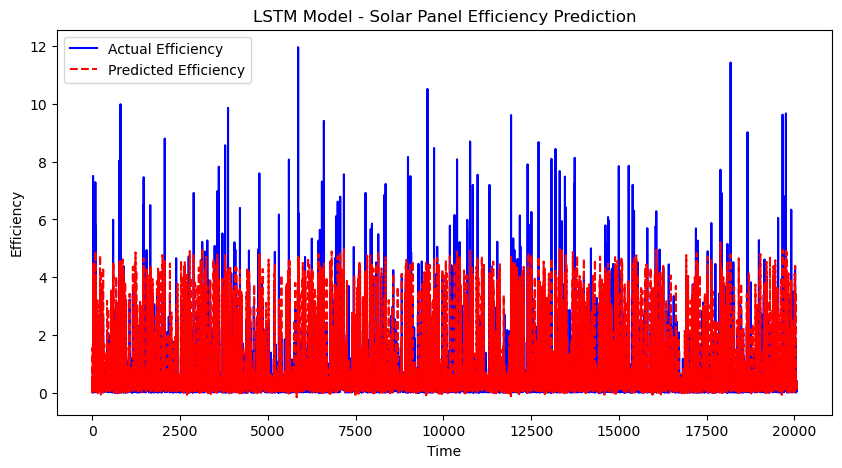

In [45]:
# Flatten lists
predictions = np.concatenate(predictions).flatten()
actuals = np.concatenate(actuals).flatten()

# Reverse MinMax scaling
predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(actuals, label="Actual Efficiency", color="blue")
plt.plot(predictions, label="Predicted Efficiency", color="red", linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Efficiency")
plt.title("LSTM Model - Solar Panel Efficiency Prediction")
plt.show()


In [47]:
# create predictions for full file
model.eval()
all_predictions = []

with torch.no_grad():
    for X_batch, _ in DataLoader(dataset, batch_size=batch_size, shuffle=False): 
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        all_predictions.append(outputs.cpu().numpy())

# Convert list to NumPy array
all_predictions = np.concatenate(all_predictions).flatten()

# Reverse MinMax scaling
predicted_efficiency = scaler_y.inverse_transform(all_predictions.reshape(-1, 1)).flatten()


In [48]:
# chech array lengths
eff_predictions = sunlab_minute.iloc[seq_length:] 
eff_predictions.loc[:, 'Predicted Efficiency'] = predicted_efficiency

C:\Users\Donva\AppData\Local\Temp\ipykernel_13052\104302378.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eff_predictions.loc[:, 'Predicted Efficiency'] = predicted_efficiency


In [49]:
eff_predictions.to_csv("Efficiency_Predictions.csv", index=False)

In [52]:
# new file columns
selected_columns = [
    'Datetime',
    'A_Optimal - Power DC [W]',
    'Ambient Temperature [ÂºC]',
    'Global Radiation [W/m2]',
    'Diffuse Radiation [W/m2]',
    'Ultraviolet [W/m2]',
    'Wind Velocity [m/s]',
    'Wind Direction [Âº]',
    'Precipitation [mm]',
    'Atmospheric pressure [hPa]',
    'Efficiency',
    'Predicted Efficiency'
]


# new df for file
eff_pred_file = eff_predictions[selected_columns].copy()


In [53]:
eff_pred_file.head()

,Datetime,A_Optimal - Power DC [W],Ambient Temperature [ÂºC],Global Radiation [W/m2],Diffuse Radiation [W/m2],Ultraviolet [W/m2],Wind Velocity [m/s],Wind Direction [Âº],Precipitation [mm],Atmospheric pressure [hPa],Efficiency,Predicted Efficiency
24,2017-01-20 08:16:00+00:00,42.28925,1.0,0.034381,0.029807,0.033968,1.0,0.917591,0.0,1.0,0.042700,0.708189
25,2017-01-20 08:17:00+00:00,43.59400,1.0,0.036538,0.031318,0.035204,1.0,0.921740,0.0,1.0,0.041454,0.710425
26,2017-01-20 08:18:00+00:00,45.19900,1.0,0.038505,0.033588,0.036369,1.0,0.927323,0.0,1.0,0.040812,0.696422
27,2017-01-20 08:19:00+00:00,46.81600,1.0,0.040167,0.033604,0.037639,1.0,0.921751,0.0,1.0,0.040545,0.668239
28,2017-01-20 08:20:00+00:00,48.20200,1.0,0.042040,0.034732,0.038916,1.0,0.923136,0.0,1.0,0.039907,0.660323


In [54]:
eff_pred_file.to_csv("Efficiency_Predictions_trimmed.csv", index=False)